## Lyft Challenge!

https://www.udacity.com/lyft-challenge

In [5]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [7]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pdb
from pathlib import Path

In [8]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

def open_image_no_norm(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of ints
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags).astype(np.float32)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

def show_img(im, figsize=(10,10), ax=None, seg=False, channel=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    new_img = np.copy(im) # Prevent the original image from being modified
    if seg:
        new_img = new_img[:,:,0] # Grab just the red channel from the RGB image
        if channel:
            new_img[new_img != channel] = 0 # Display only the requested classes (roads etc)
    ax.imshow(new_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

PATH = Path('train')

In [9]:
list(PATH.iterdir())

[PosixPath('train/CameraSeg'),
 PosixPath('train/train_128'),
 PosixPath('train/train_masks_128'),
 PosixPath('train/CameraRGB')]

In [10]:
RGB_PATH = PATH/'CameraRGB'
list(RGB_PATH.iterdir())[:5]

[PosixPath('train/CameraRGB/5.png'),
 PosixPath('train/CameraRGB/88.png'),
 PosixPath('train/CameraRGB/0.png'),
 PosixPath('train/CameraRGB/128.png'),
 PosixPath('train/CameraRGB/406.png')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(600, 800, 3)


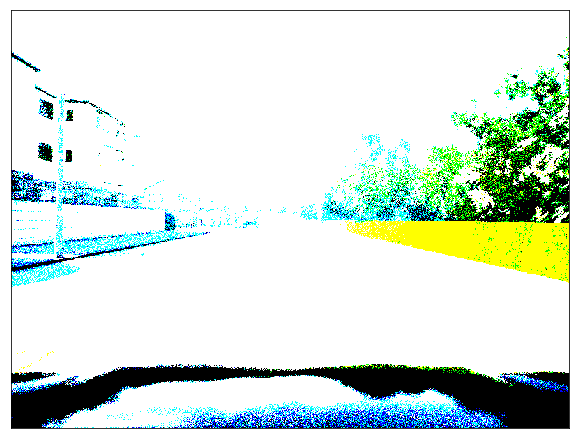

In [11]:
test_RGB_image = open_image_no_norm(next(RGB_PATH.iterdir()))
print(test_RGB_image.shape)
show_img(test_RGB_image);

In [12]:
seg_PATH = PATH/'CameraSeg'
list(seg_PATH.iterdir())[:5]

[PosixPath('train/CameraSeg/5.png'),
 PosixPath('train/CameraSeg/88.png'),
 PosixPath('train/CameraSeg/0.png'),
 PosixPath('train/CameraSeg/128.png'),
 PosixPath('train/CameraSeg/406.png')]

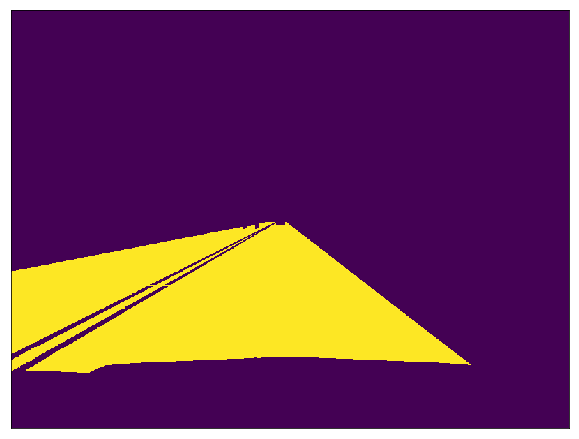

In [13]:
test_seg_image = open_image_no_norm(next(seg_PATH.iterdir()))
show_img(test_seg_image, seg=True, channel=ROADS)

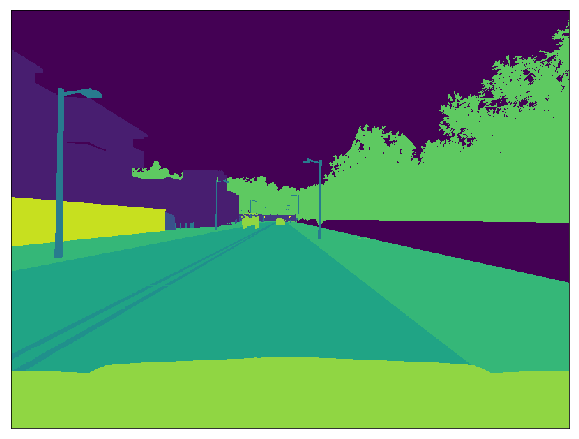

In [14]:
show_img(test_seg_image, seg=True)

Now that I have a feel for how the dataset looks, let's downsize the images for training

In [15]:
(PATH/'train_masks_128').mkdir(exist_ok=True)
(PATH/'train_128').mkdir(exist_ok=True)

In [16]:
def resize_mask(filename, size=128):
    Image.open(filename).resize((size,size)).save((filename.parent.parent)/'train_masks_128'/filename.name)
    
def resize_img(filename, size=128):
    Image.open(filename).resize((size,size)).save((filename.parent.parent)/'train_128'/filename.name)

In [17]:
masks = list(seg_PATH.iterdir())
imgs = list(RGB_PATH.iterdir())

# print(masks[:5])
# print(imgs[:5])

# with ThreadPoolExecutor(8) as e: e.map(resize_mask, masks)
# with ThreadPoolExecutor(8) as e: e.map(resize_img, imgs)

In [18]:
TRAIN_DN = 'train_128'
MASKS_DN = 'train_masks_128'
sz = 128
bs = 64

print(list((PATH/TRAIN_DN).iterdir())[:5])

[PosixPath('train/train_128/5.png'), PosixPath('train/train_128/88.png'), PosixPath('train/train_128/0.png'), PosixPath('train/train_128/128.png'), PosixPath('train/train_128/406.png')]


In [19]:
class MatchedFilesDatset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        assert(len(filenames == len(y)))
        self.y = y
        super().__init__(filenames, transform, path)
        
    def get_y(self, i): return open_image_no_norm(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

In [20]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

len(x_names), len(y_names)

(1000, 1000)

In [21]:
val_idxs = list(range(len(x_names)//5)) # 20% validation split
((val_x, trn_x),(val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names) # split the in/out pairs the same

In [22]:
len(val_x),len(trn_x)
trn_x[:2]

array([PosixPath('train/train_128/284.png'), PosixPath('train/train_128/595.png')], dtype=object)

In [23]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [24]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [25]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [26]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/officialdanielhunter/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 109031425.54it/s]


OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [27]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [28]:
flatten_channel = Lambda(lambda x: x[:,0])

In [29]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [30]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

epoch      trn_loss   val_loss   <lambda>                   
    0      -299.331521 -1852048286.72 0.143286  



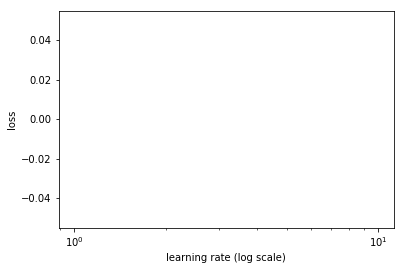

In [31]:
learn.lr_find()
learn.sched.plot()

In [32]:
lr=4e-2

In [33]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      -42.196615 -1351.384702 0.23755   
    1      -410.761632 -2768.436924 0.307216              
    2      -1196.245383 -3902.806816 0.315682                  
    3      -2229.639709 -5200.275547 0.317275                  
    4      -3247.125002 -6117.301953 0.305393                  



[array([-6117.30195]), 0.30539276123046877]

In [34]:
learn.save('tmp')

In [35]:
learn.load('tmp')

In [36]:
py,ay = learn.predict_with_targs()

In [37]:
ay.shape

(200, 128, 128)

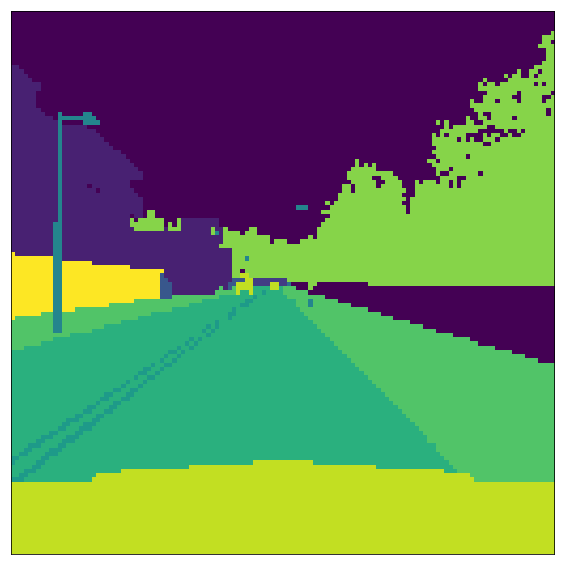

In [38]:
show_img(ay[0]);

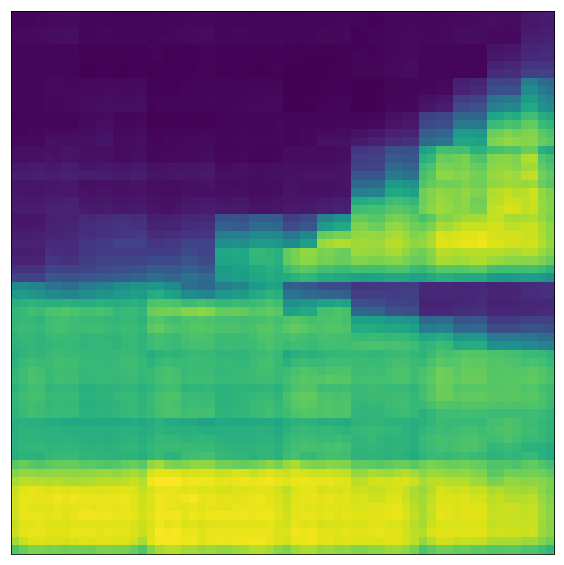

In [40]:
show_img(py[0]);